In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]

def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

2024-09-03 13:08:19.794180: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-03 13:08:20.109352: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [3]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240819'

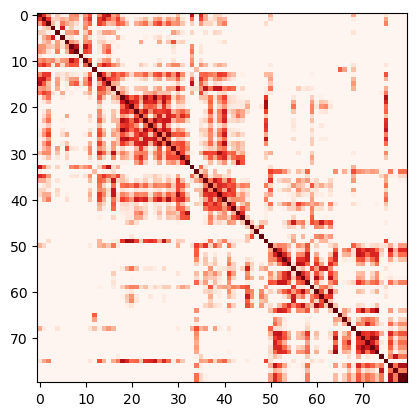

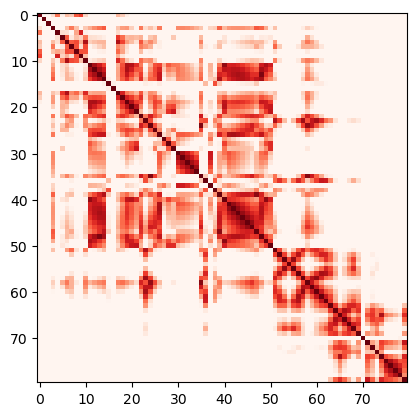

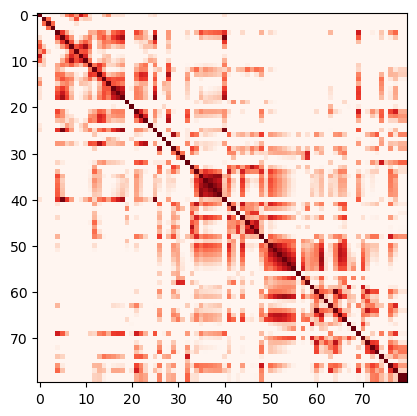

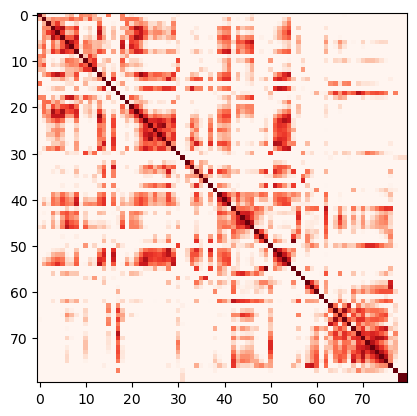

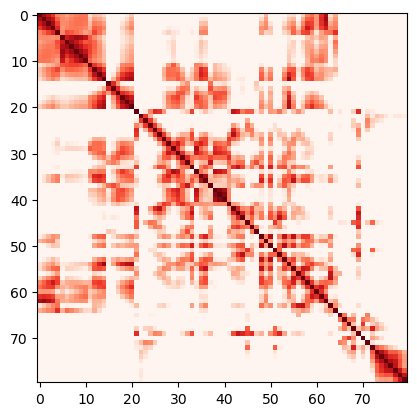

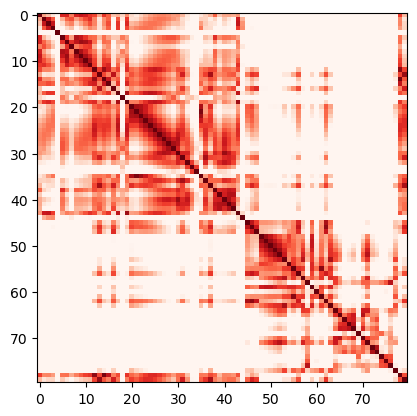

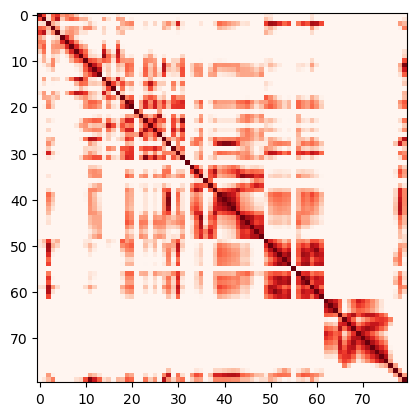

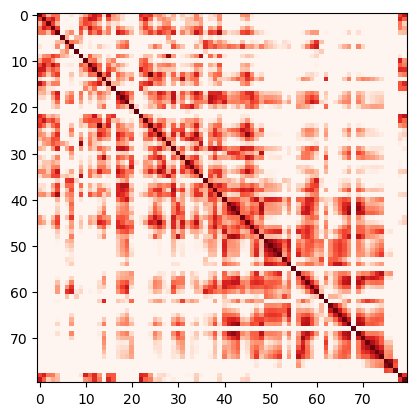

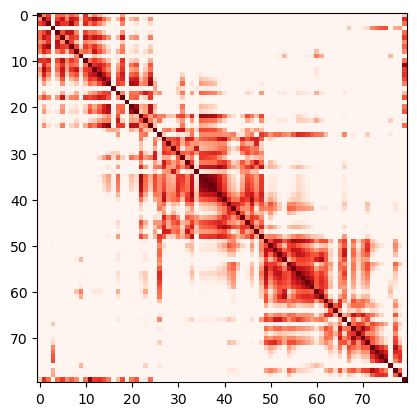

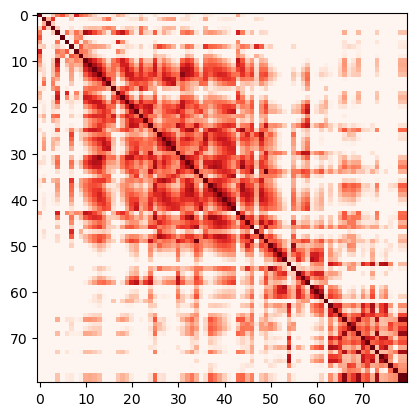

In [34]:
for i, dmap in enumerate(esc_maps_interp[:10]):
    plt.imshow(dmap, cmap='Reds_r', vmin=0, vmax=500)
    plt.savefig(os.path.join(save_dir, f'esc_map_{i}.png'), dpi=300)
    plt.show()

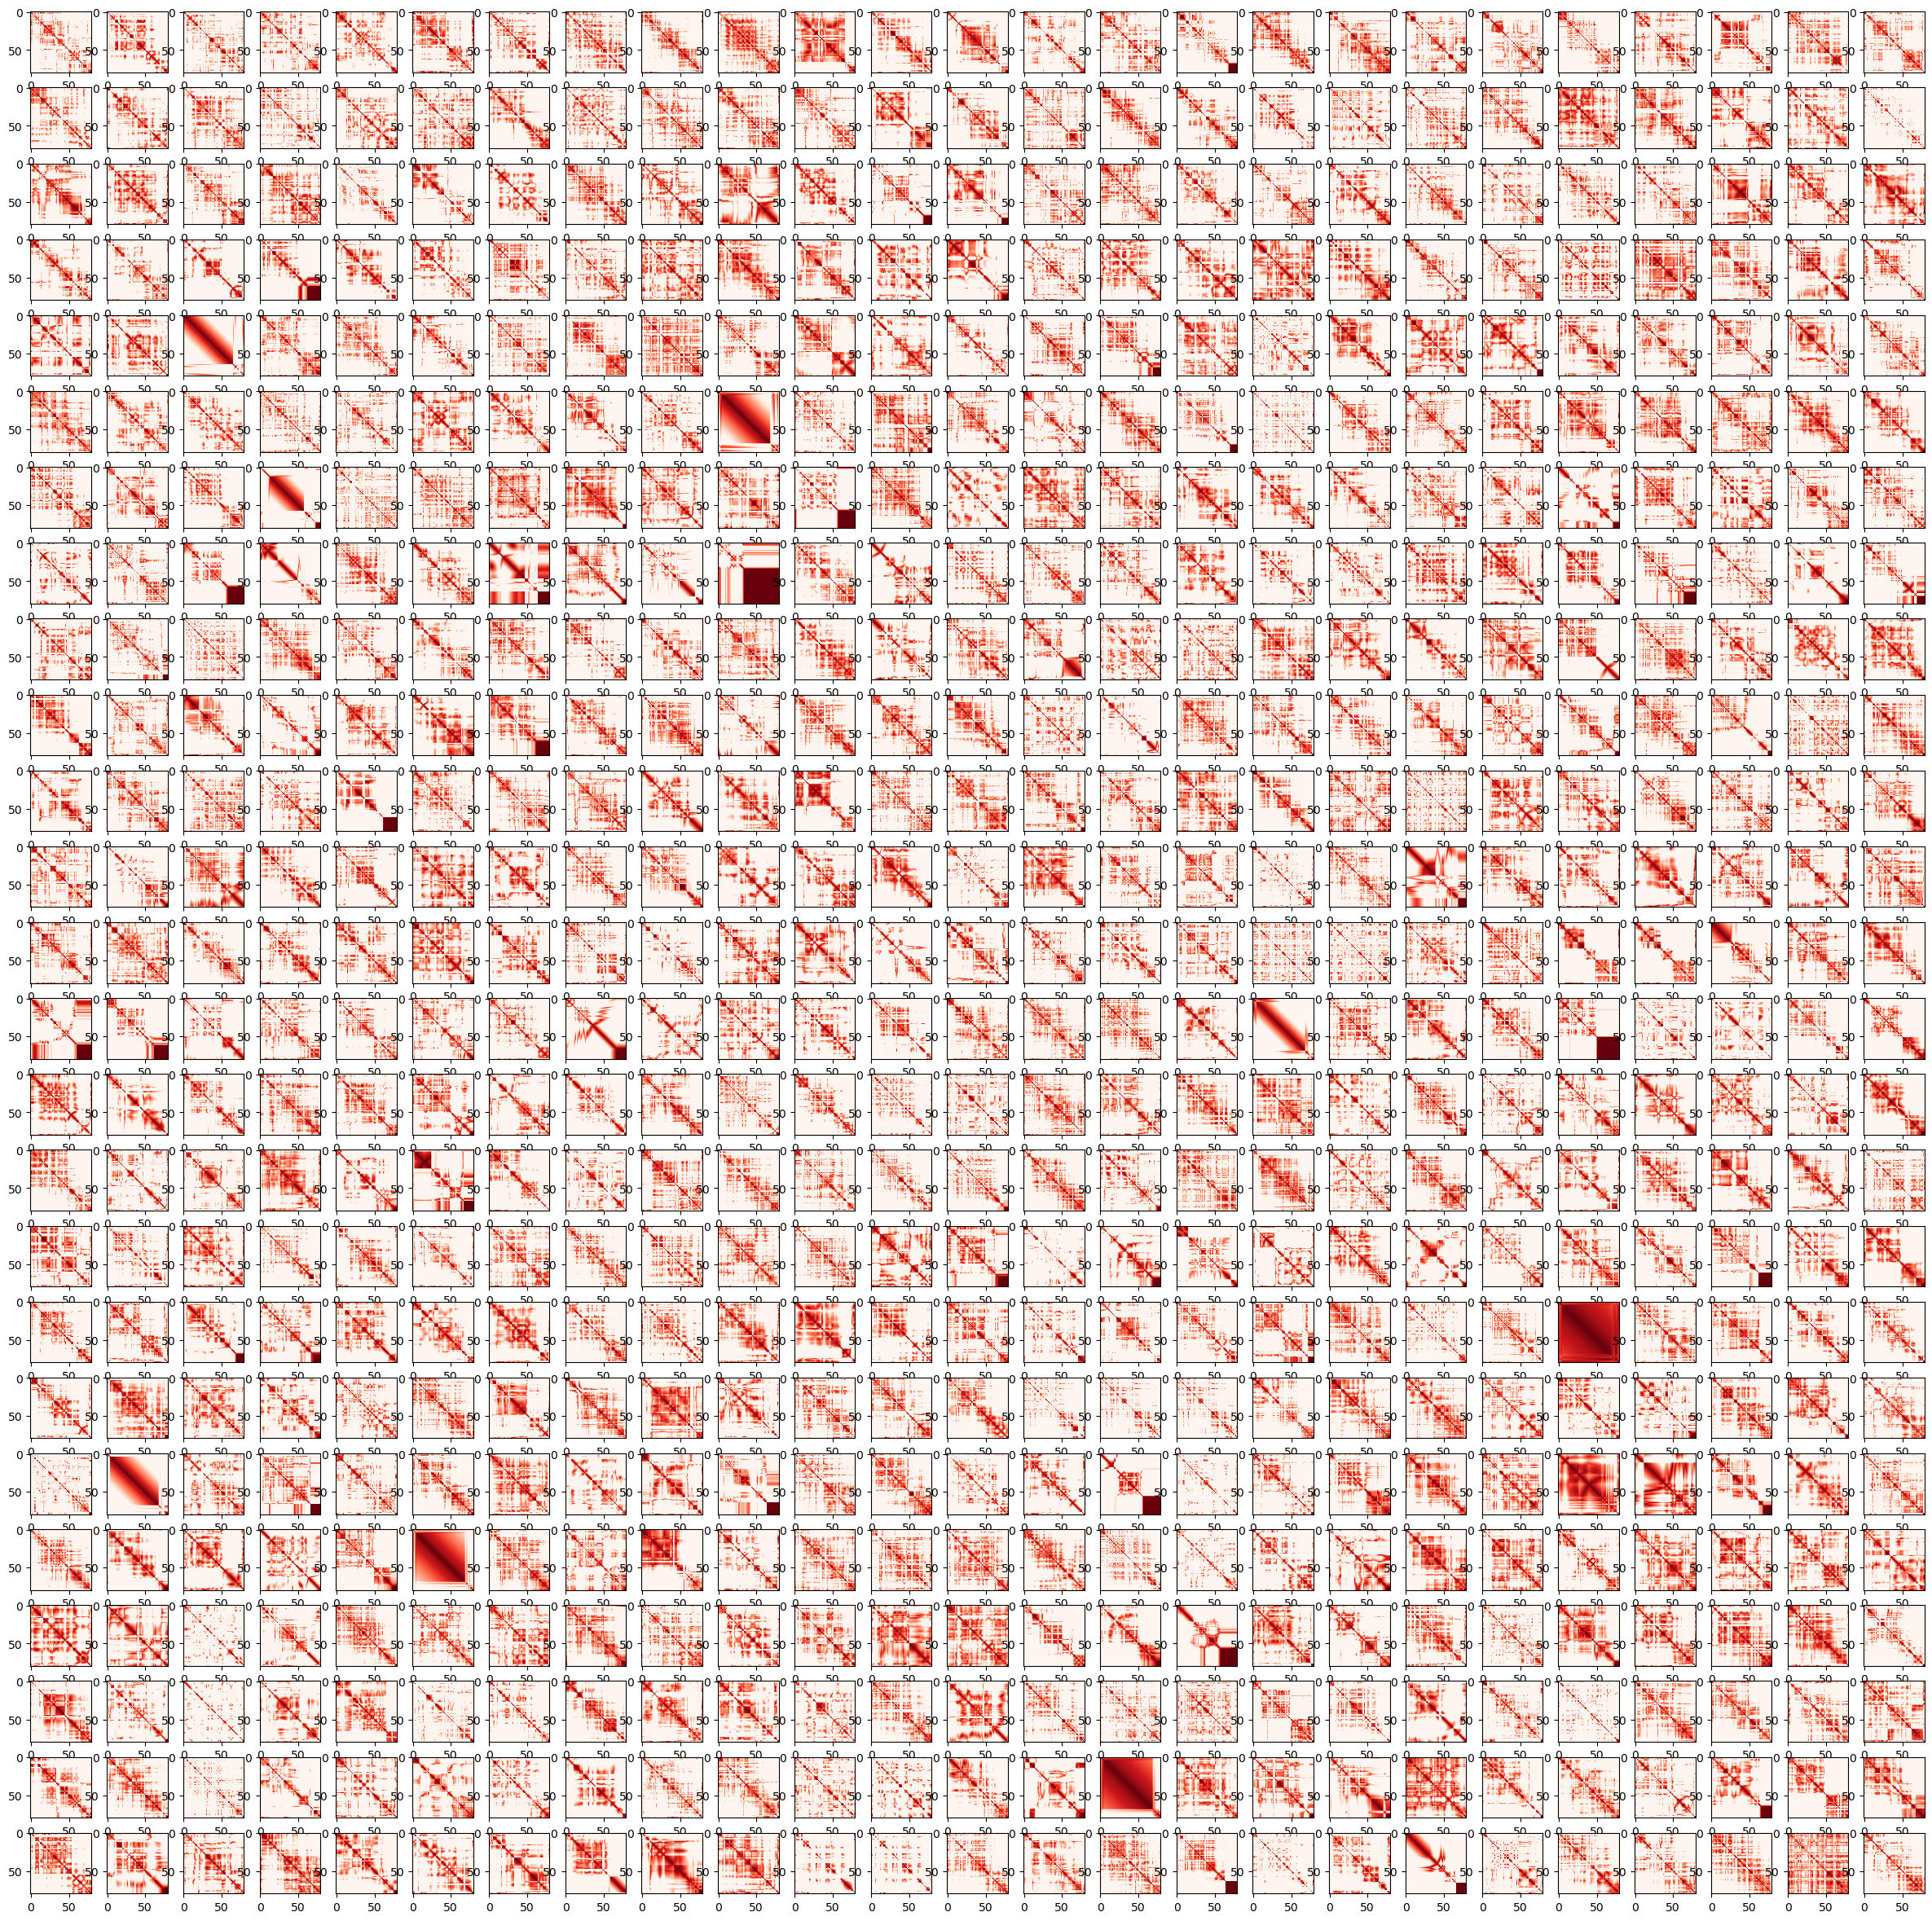

In [7]:
# Plot 9 random maps in a 3x3 grid
# No gap between subplots
plt.figure(figsize=(30, 30))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
for i in range(25**2):
    plt.subplot(25, 25, i+1)
    plt.imshow(esc_maps_interp[i], cmap='Reds_r', vmin=0, vmax=500)
plt.savefig(os.path.join(save_dir, 'esc_maps_25x25.png'), dpi=300)

In [3]:
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [23]:
def plot_spline_3d(points, save_path=None):
    """
    Plots a 3D spline interpolation of the given points.

    Parameters:
    - points: numpy array of shape (n, 3), where n is the number of points.
    - save_path: Optional. If provided, the plot will be saved to this path.
    """

    # Unpack the points into x, y, z
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    # Perform spline interpolation
    tck, u = splprep([x, y, z], s=0, k=3)
    u_fine = np.linspace(0, 1, 100)  # Generate fine parameterization
    x_fine, y_fine, z_fine = splev(u_fine, tck)

    # Plotting the original points and the interpolated spline
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot original points
    ax.plot(x, y, z, 'bo', label='Original Points')

    # Plot spline
    ax.plot(x_fine, y_fine, z_fine, 'r-', label='Spline Interpolation')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()

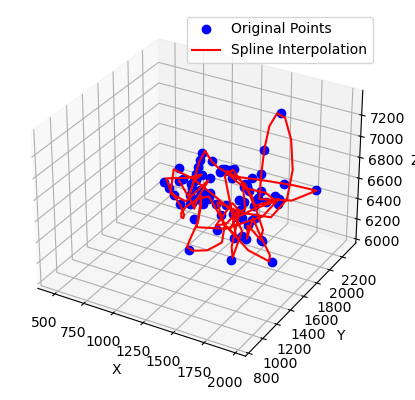

In [27]:
plot_spline_3d(esc_polys_interp[:, :, 6])